In [ ]:
#!/usr/bin/env python
# # -*- coding: utf-8 -*-
#!/usr/bin/env python
#!pip install tensorflow==1.15

import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os, inspect
import argparse
import time
import seaborn as sns
# import matplotlib
# matplotlib.use("Qt5Agg")
# #matplotlib.use('Agg')
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
import pandas as pd
import sys,inspect
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Postprocess")
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Methods\\Models\\Utils")

import utils  # for utils.py
from utils import *
import global_utils  # for global_utils.py

# import utils
# from utils import *
# import sys
# sys.path.append('../Methods/Models/Utils')
# import global_utils

: 

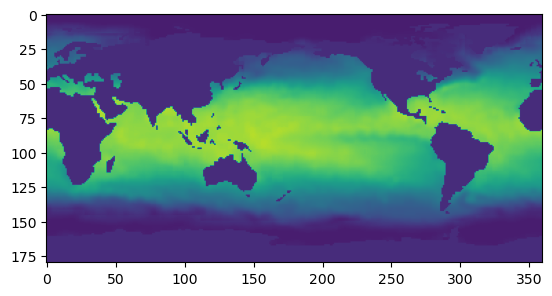

In [2]:
train_data = np.load('Data/sst_var_train',allow_pickle=True).data
mask = np.load('Data/mask',allow_pickle=True)
plt.imshow(train_data[0]*mask[0],vmin=-5,vmax=35)

In [3]:
train_data_ml = train_data.reshape(427,180*360)
mask = mask[0].flatten()
mask = np.asarray(mask,dtype='bool')

train_data_ml = train_data_ml[:,mask]
train_data_ml.shape

# Find train data mean
train_data_mean = np.mean(train_data_ml,axis=0)
train_data_ml = train_data_ml - train_data_mean[None,]

In [4]:
def field_compression(Y,K):
    '''
    Y - Snapshot matrix - shape: NxS
    K - number of modes to truncate to
    returns 
    V - truncated POD basis matrix - shape: NxK
    Ytilde - truncated coefficient matrix - shape: KxS
    '''
    V = generate_pod_bases(Y,K)
    Ytilde = field_coefficients(Y,V)

    return V, Ytilde

def generate_pod_bases(Y,K): #Mean removed
    '''
    Y - Snapshot matrix - shape: NxS
    returns V - truncated POD basis matrix - shape: NxK
    '''
    new_mat = np.matmul(np.transpose(Y),Y)
    w,v = np.linalg.eig(new_mat)

    # plt.figure()
    # plt.semilogy(w[:]/np.sum(w)*100)
    # plt.show()

    # Bases
    V = np.real(np.matmul(Y,v)) 
    trange = np.arange(np.shape(V)[1])
    V[:,trange] = V[:,trange]/np.sqrt(w[:])

    # Truncate phis
    V = V[:,0:K] # Columns are modes

    return V

def field_coefficients(Y,V):
    '''
    Y - Snapshot matrix - shape: NxS
    V - truncated POD basis matrix - shape: NxK
    returns Ytilde - shape: KxS
    '''
    return np.matmul(np.transpose(V),Y)

c:\Anaconda\envs\hqr\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


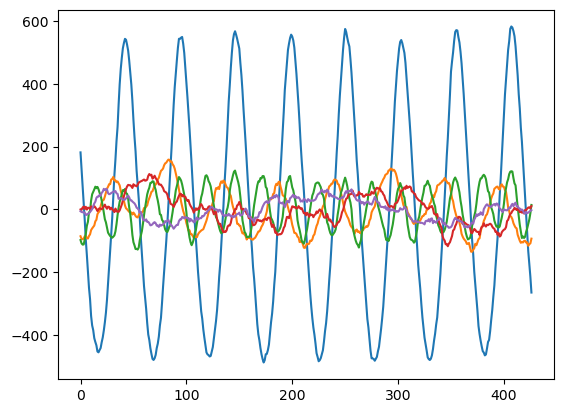

In [5]:
modes, coeffs = field_compression(train_data_ml.T,5)
plt.figure()
plt.plot(coeffs[0,:])
plt.plot(coeffs[1,:])
plt.plot(coeffs[2,:])
plt.plot(coeffs[3,:])
plt.plot(coeffs[4,:])
plt.show()

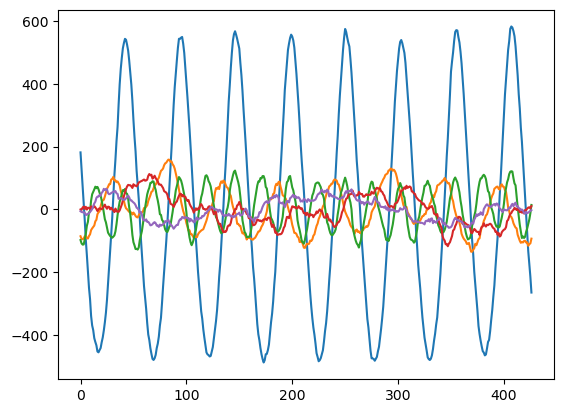

In [6]:
data_train = coeffs.T
plt.figure()
plt.plot(data_train[:,0])
plt.plot(data_train[:,1])
plt.plot(data_train[:,2])
plt.plot(data_train[:,3])
plt.plot(data_train[:,4])
plt.show()

In [10]:
# with open("./Simulation_Data/lorenz3D_data.pickle", "rb") as file:
#     # Pickle the "data" dictionary using the highest protocol available.
#     data = pickle.load(file)
#     u = data["u"]
#     sigma = data["sigma"]
#     beta = data["beta"]
#     rho = data["rho"]
#     dt = data["dt"]
n = data_train.shape[0]
dt = 1
N_train = 427
N_test = 427
sigma = -1
beta = -1
rho = -1

# dudt = (u[1:]-u[:-1])/dt
# u = u[:-1,:]

# u_train = u[:N_train, :]
# u_test = u[N_train:N_train+N_test, :]

# dudt_train = dudt[:N_train, :]
# dudt_test = dudt[N_train:N_train+N_test, :]
u_train = data_train[:N_train,:]
u_test = data_train[:N_test,:]
#u_test = data_valid[:-1,:]
#dudt_train = (data_train[1:]-data_train[:-1])/dt #why du/dt
#dudt_train = dudt_train[:N_train]
#dudt_test = (data_valid[1:]-data_valid[:-1])/dt
#dudt_test = dudt_test[:]
train_input_sequence = u_train
#train_target_sequence = dudt_train
train_target_sequence = u_train
test_target_sequence = u_test
test_input_sequence = u_test
#test_target_sequence = dudt_test

print("Number of training samples: {}".format(train_input_sequence.shape))
print("Number of testing samples: {}".format(test_input_sequence.shape))

attractor_std = np.std(train_input_sequence, axis=0)

dl_max = 40
pl_max = 300
max_idx = np.shape(train_input_sequence)[0] - pl_max
min_idx = dl_max
idx = np.arange(min_idx, max_idx)
#np.random.shuffle(idx)
testing_ic_indexes = idx

print("Shape of initial conditions: {:}".format(testing_ic_indexes.shape))

data = {
"train_input_sequence":train_input_sequence,
"train_target_sequence":train_target_sequence,
"attractor_std":attractor_std,
"dt":dt,"sigma":sigma,
"beta":beta,
"rho":rho,
}

with open("./Data/training_data_N{:d}.pickle".format(N_train), "wb") as file:
    # Pickle the "data" dictionary using the highest protocol available.
    pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)

data = {
"test_input_sequence":test_input_sequence,
"test_target_sequence":test_target_sequence,
"attractor_std":attractor_std,
"testing_ic_indexes":testing_ic_indexes,
"dt":dt,"sigma":sigma,
"beta":beta,
"rho":rho,
}

with open("./Data/testing_data_N{:d}.pickle".format(N_train), "wb") as file:
    # Pickle the "data" dictionary using the highest protocol available.
    pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)

Number of training samples: (427, 5)
Number of testing samples: (427, 5)
Shape of initial conditions: (87,)


In [8]:
sysname, tidx = "SST", 2
file_path = os.path.abspath("data_analysis.ipynb")
current_directory = os.path.dirname(file_path)
mid_directory = os.path.dirname(current_directory)
parent_directory = os.path.dirname(mid_directory)

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

#current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
results_dir = os.path.join(os.path.dirname(mid_directory), "Results")  # Use os.path.join for path concatenation
print(results_dir)

eval_path = os.path.join(results_dir, sysname, 'Evaluation_Data')
print(eval_path)

model_path = os.path.join(results_dir, sysname, 'Trained_Models')
print(model_path)

fig_path = os.path.join(results_dir, sysname, 'Eval_Figures')
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)  # Use os.makedirs to create parent directories if needed
print(fig_path)

Current Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Data\SST
Parent Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Evaluation_Data
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Trained_Models
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Eval_Figures


In [12]:
maxLyp = 1.0
dt = 1
trained_models = None

In [11]:
models = [[os.path.join(eval_path, "hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_20-IUL_0-REG_1e-07-AU_0-NICS_3"),"HQR-5,V-10,DL=40,IPL=20,n_tests=3"],
          [os.path.join(eval_path, "hqrc_pinv-RDIM_5-N_used_427-DL_8-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_8-IUL_0-REG_1e-07-AU_0-NICS_1"),"HQR-5,V-10,DL=8,IPL=8,n_tests=1"],
          [os.path.join(eval_path, "hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_1"),"HQR-5,V-10,DL=40,IPL=300,n_tests=1"]]
samples = ["HQR-5,V-10,DL=40,IPL=20,n_tests=3","HQR-5,V-10,DL=8,IPL=8,n_tests=1","HQR-5,V-10,DL=40,IPL=300,n_tests=1"]
title = "Sea Surface Temperatures"

In [13]:
rmse_dict = dict()
vpt_dict = dict()
targets = dict()
outputs = dict()
sp_outputs = dict()
sp_targets = dict()
Wouts = dict()
coeffs = dict()

for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'results.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            qs = QResults()
            qs.rmnse_avg_test = rs['rmnse_avg_TEST']
            qs.rmnse_avg_train = rs['rmnse_avg_TRAIN']
            qs.n_pred_005_avg_test = rs['num_accurate_pred_005_avg_TEST']
            qs.n_pred_005_avg_train = rs['num_accurate_pred_005_avg_TRAIN']
            qs.n_pred_050_avg_test = rs['num_accurate_pred_050_avg_TEST']
            qs.n_pred_050_avg_train = rs['num_accurate_pred_050_avg_TRAIN']
            qs.model_name = rs['model_name']
            #if qs.rmnse_avg_test != np.inf and qs.rmnse_avg_train != np.inf:
                #print(rs.keys())
            #print(qs.model_name)
            #print('train={}, test={}'.format(qs.rmnse_avg_train, qs.rmnse_avg_test))
            #qs.info()

            pred_test = rs['predictions_all_TEST']
            truth_test = rs['truths_all_TEST']
            M = len(pred_test)
            print('{} Number of test'.format(qs.model_name), M)
            rmsels = []
            vpts = []
            for j in range(M):
                    rmsels.append(calNRMSE(pred_test[j], truth_test[j]))
                    vpts.append(calVPT(pred_test[j], truth_test[j],dt=dt, maxLyp=maxLyp))##

            rmse_dict[label] = np.mean(np.array(rmsels), axis=0)
            print(rmse_dict[label].shape)

            vpt_dict[label] = np.array(vpts)

            targets[label] = truth_test[0]
            outputs[label] = pred_test[0]

            # For frequency
            sp_outputs[label] = rs['sp_pred_TEST']
            sp_targets[label] = rs['sp_true_TEST']
    else:
        print('Not found {}'.format(fname))

    if trained_models is not None:
        rfolder, label = trained_models[i][0], trained_models[i][1]
        fname = os.path.join(rfolder, 'data.pickle')
        if os.path.isfile(fname):
            print('File existed: ', fname)
            with open(fname, 'rb') as rfile:
                #try:
                rs = pickle.load(rfile)
                #except:
                #    continue
                print(rs.keys())
                coeffs[label] = np.array(rs['coeffs'])
                Wouts[label]  = rs['W_out'][:-1].reshape((coeffs[label].shape[0], -1))
                print(Wouts[label].shape, coeffs[label].shape)
        else:
            print('Not found saved model {}'.format(fname))

hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_20-IUL_0-REG_1e-07-AU_0-NICS_3 Number of test 3
(20,)
hqrc_pinv-RDIM_5-N_used_427-DL_8-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_8-IUL_0-REG_1e-07-AU_0-NICS_1 Number of test 1
(8,)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_1 Number of test 1
(300,)


In [14]:
def normalize_array(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val)

In [15]:
# PLOTTING
cmap = plt.get_cmap("RdBu")
ecmap = plt.get_cmap("summer_r")
#plt.style.use('seaborn-colorblind')
plt.rc('font', family='serif')
plt.rc('mathtext', fontset='cm')
plt.rcParams['font.size']=9
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

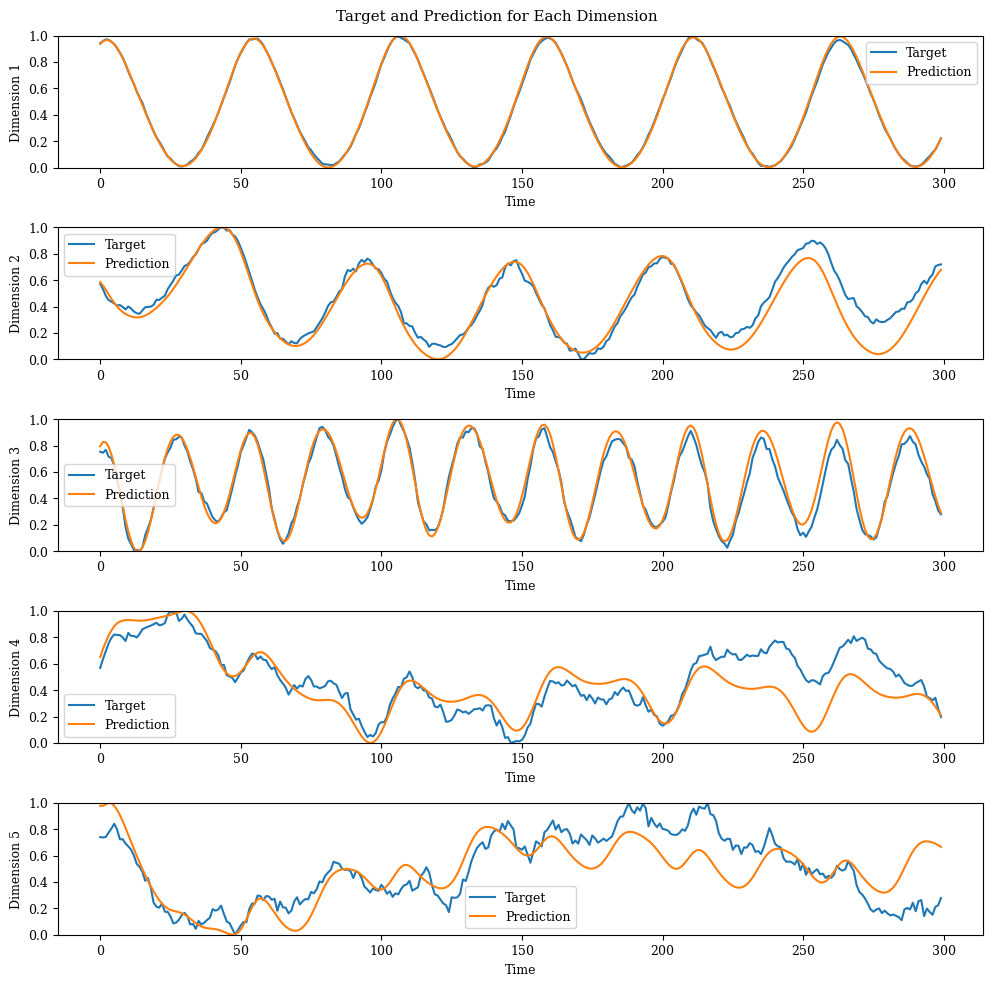

In [16]:
label = samples[2]
temp_target = targets[label]
temp_out = outputs[label]
num_dimensions = temp_target.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(10, 10))
# Iterate over each dimension
for dim in range(num_dimensions):
    # Normalize target and output arrays for current dimension
    target_dim = temp_target[:, dim]
    out_dim = temp_out[:, dim]
    
    norm_target_dim = normalize_array(target_dim)
    norm_out_dim = normalize_array(out_dim)
    
    # Plot target and output arrays
    axs[dim].plot(norm_target_dim, label='Target')
    axs[dim].plot(norm_out_dim, label='Prediction')
    
    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)
    
    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim+1}')
    axs[dim].legend()

# Add title
plt.suptitle('Target and Prediction for Each Dimension')
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()

In [27]:
np.allclose(temp_target[pl_max-1],data_train[dl_max+pl_max-1]) ##dl_max'th week is being predicted

True

In [28]:
print(data_train[dl_max+pl_max-1])
print(temp_out[pl_max-1])

[-251.78888    79.78663   -57.664387  -43.183533  -26.46627 ]
[-249.85383404   67.50737921  -52.14596305  -50.14109459    9.56836443]


In [29]:
recon_data_ml = np.matmul(modes,data_train[dl_max+pl_max-1].T).T
recon_data_ml = recon_data_ml + train_data_mean[None,]
recon_data = np.copy(train_data[dl_max+pl_max-1])
recon_data = recon_data.reshape(1,180*360)
recon_data[0,mask] = recon_data_ml
recon_data = recon_data.reshape(1,180,360)

pred_data_ml = np.matmul(modes,temp_out.T).T
pred_data_ml = pred_data_ml + train_data_mean[None,]
pred_data = np.copy(train_data[dl_max:dl_max+pl_max])
pred_data = pred_data.reshape(pl_max,180*360)
pred_data[:,mask] = pred_data_ml
pred_data = pred_data.reshape(pl_max,180,360)
new_mask = np.load('Data/mask',allow_pickle=True)

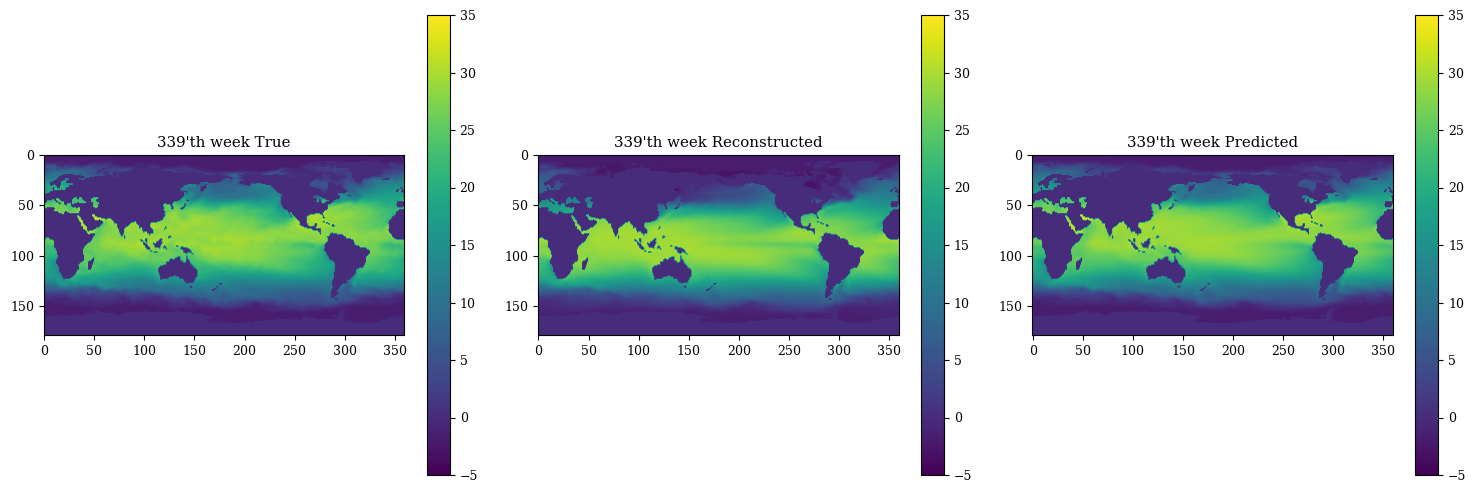

In [34]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
axs[0].imshow(train_data[dl_max+pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[0].set_title("{}'th week True".format(dl_max+pl_max-1))
fig.colorbar(axs[0].imshow(train_data[dl_max] * new_mask[0], vmin=-5, vmax=35), ax=axs[0], orientation='vertical')

# Plot the second subplot
axs[1].imshow(recon_data[0] * mask[0], vmin=-5, vmax=35)
axs[1].set_title("{}'th week Reconstructed".format(dl_max+pl_max-1))
fig.colorbar(axs[1].imshow(recon_data[0] * new_mask[0], vmin=-5, vmax=35), ax=axs[1], orientation='vertical')

# Plot the third subplot
axs[2].imshow(pred_data[pl_max-1] * mask[0], vmin=-5, vmax=35)
axs[2].set_title("{}'th week Predicted".format(dl_max+pl_max-1))
fig.colorbar(axs[2].imshow(pred_data[0] * new_mask[0], vmin=-5, vmax=35), ax=axs[2], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

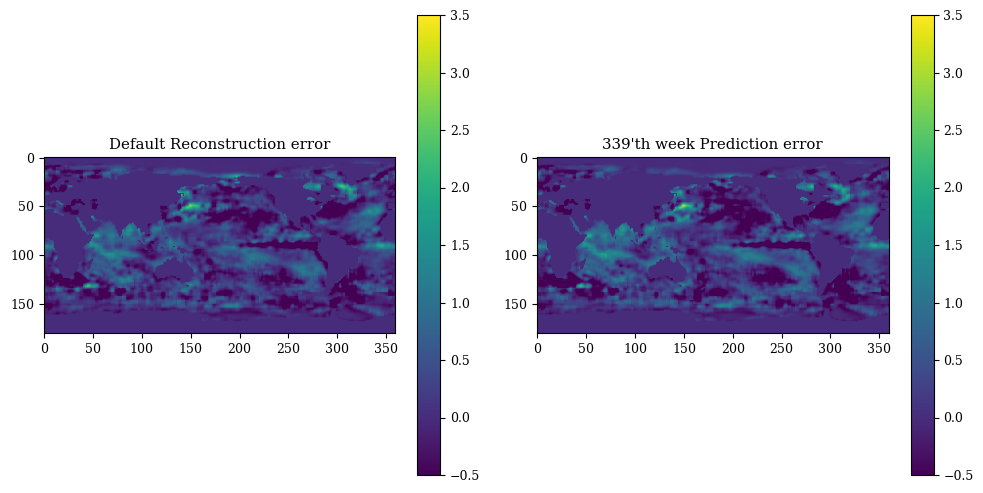

In [44]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
im1 = axs[0].imshow((train_data[dl_max+pl_max-1] - recon_data[0]) * new_mask[0], vmin=-0.5, vmax=3.5)
axs[0].set_title("Default Reconstruction error")
fig.colorbar(im1, ax=axs[0], orientation='vertical')

# Plot the second subplot
im2 = axs[1].imshow((train_data[dl_max+pl_max-1] - pred_data[pl_max-1]) * new_mask[0], vmin=-0.5, vmax=3.5)
axs[1].set_title("{}'th week Prediction error".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

In [43]:
temp_true = train_data[dl_max:dl_max+pl_max]
rmse_pred = np.sqrt(np.mean((temp_true-pred_data)**2))
print(rmse_pred)

0.5002304
